In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import os

In [2]:
# Full dataset
df_full = pd.read_csv(
    "/Users/kawtharalelg/Desktop/Term 251/AI Research/Edited Manuscript Code/Entire Dataset/run_level_kfold_results_full.csv"
)

# Naphtha cluster-guided dataset
df_naphtha = pd.read_csv(
    "/Users/kawtharalelg/Desktop/Term 251/AI Research/Edited Manuscript Code/Cluster Guided/Naphtha/run_level_kfold_results_naphtha.csv"
)

# VGO cluster-guided dataset
df_vgo = pd.read_csv(
    "/Users/kawtharalelg/Desktop/Term 251/AI Research/Edited Manuscript Code/Cluster Guided/Vacuum Gas Oil/run_level_kfold_results_vgo.csv"
)

df_full.head(), df_naphtha.head(), df_vgo.head()


(  Model  BO      Target  Fold      RMSE       MAE        R2  Pearson_r
 0   GPR  No  Conversion     1  0.211034  0.142516  0.852343   0.599520
 1   GPR  No  Conversion     2  2.580575  1.202048 -3.125497   0.697156
 2   GPR  No  Conversion     3  0.848756  0.424631  0.340840  -0.386228
 3   GPR  No  Conversion     4  1.094138  0.550145 -0.350576   0.460394
 4   GPR  No  Conversion     5  0.520155  0.280861  0.668284  -0.215120,
   Model  BO      Target  Fold      RMSE       MAE        R2  Pearson_r
 0   GPR  No  Conversion     1  0.214896  0.150825  0.938254   0.420118
 1   GPR  No  Conversion     2  0.190694  0.156255  0.961380   0.294418
 2   GPR  No  Conversion     3  0.123190  0.085550  0.985150   0.989982
 3   GPR  No  Conversion     4  0.062911  0.050714  0.893869   0.981066
 4   GPR  No  Conversion     5  0.032598  0.022789  0.998972   0.693183,
   Model  BO      Target  Fold      RMSE       MAE        R2  Pearson_r
 0   GPR  No  Conversion     1  0.240706  0.205314  0.893195  

In [3]:
df_full["dataset"] = "full"
df_vgo["dataset"] = "vgo"
df_naphtha["dataset"] = "naphtha"
# concat the data
df = pd.concat([df_full, df_vgo, df_naphtha], ignore_index=True)

In [4]:
df["dataset"].value_counts()

dataset
full       60
vgo        60
naphtha    60
Name: count, dtype: int64

In [5]:
print(df)

    Model   BO          Target  Fold      RMSE       MAE        R2  Pearson_r  \
0     GPR   No      Conversion     1  0.211034  0.142516  0.852343   0.599520   
1     GPR   No      Conversion     2  2.580575  1.202048 -3.125497   0.697156   
2     GPR   No      Conversion     3  0.848756  0.424631  0.340840  -0.386228   
3     GPR   No      Conversion     4  1.094138  0.550145 -0.350576   0.460394   
4     GPR   No      Conversion     5  0.520155  0.280861  0.668284  -0.215120   
..    ...  ...             ...   ...       ...       ...       ...        ...   
175   RLR  Yes  Gasoline Yield     1  0.593064  0.567867  0.400614  -0.109561   
176   RLR  Yes  Gasoline Yield     2  0.924475  0.701702  0.262577   0.097508   
177   RLR  Yes  Gasoline Yield     3  0.378704  0.274630  0.826995   0.881856   
178   RLR  Yes  Gasoline Yield     4  0.192108  0.184335  0.812361   0.975280   
179   RLR  Yes  Gasoline Yield     5  0.481610  0.370547  0.759407   0.776449   

     dataset  
0       full

In [6]:
# =============================================================================
# Build hierarchical summary table and save as CSV
# Model × BO × Dataset × Target × Metric
# Rounded to 3 decimals
# =============================================================================

all_rows = []

for model in df["Model"].unique():
    for bo in df["BO"].unique():
        for dataset in df["dataset"].unique():
            for target in df["Target"].unique():

                sub = df[
                    (df["Model"] == model) &
                    (df["BO"] == bo) &
                    (df["dataset"] == dataset) &
                    (df["Target"] == target)
                ].copy()

                if sub.empty:
                    continue

                # Remove Fold if present
                if "Fold" in sub.columns:
                    sub = sub.drop(columns=["Fold"])

                numeric = sub.select_dtypes(include="number")

                # Describe numeric columns
                desc = numeric.describe().T.reset_index()
                desc.rename(columns={"index": "Metric"}, inplace=True)

                # Insert identifying columns
                desc.insert(0, "Target", target)
                desc.insert(0, "Dataset", dataset)       # <-- Added
                desc.insert(0, "BO", bo)
                desc.insert(0, "Model", model)

                all_rows.append(desc)

# Combine everything
summary = pd.concat(all_rows, ignore_index=True)

# Round values
num_cols = summary.select_dtypes(include="number").columns
summary[num_cols] = summary[num_cols].round(3)

# Save as CSV
summary.to_csv("Model_BO_Dataset_Target_Describe_Summary.csv", index=False)

print("Saved summary as: Model_BO_Dataset_Target_Describe_Summary.csv")


Saved summary as: Model_BO_Dataset_Target_Describe_Summary.csv


In [7]:
# ============================================================================
# SAVEABLE p-value plots
# One figure PER MODEL
# Each figure contains:
#   - Conversion (2x2 subplots)
#   - Gasoline Yield (2x2 subplots)
#   -> Total 8 subplots per model
#
# Shows ALL p-values (no masking)
# ============================================================================

# -------------------------------------------------------
# Configuration
# -------------------------------------------------------
datasets = ["full", "vgo", "naphtha"]
bo_states = ["No-BO", "BO"]
metrics = ["RMSE", "MAE", "R2", "Pearson_r"]

models = df["Model"].unique()
targets_to_include = ["Conversion", "Gasoline Yield"]


# -------------------------------------------------------
# Combo labels (6 entries)
# -------------------------------------------------------
def combo_label(bo, ds):
    return f"{bo}_{ds}"

all_combos = [(bo, ds) for bo in bo_states for ds in datasets]
labels = [combo_label(bo, ds) for bo, ds in all_combos]


# -------------------------------------------------------
# Compute 6x6 p-value matrix
# -------------------------------------------------------
def compute_full_pmatrix(sub):
    pmat = pd.DataFrame(index=labels, columns=labels, dtype=float)

    for (bo1, ds1), (bo2, ds2) in itertools.product(all_combos, all_combos):

        label1 = combo_label(bo1, ds1)
        label2 = combo_label(bo2, ds2)

        if label1 == label2:
            pmat.loc[label1, label2] = 1.0
            continue

        a = sub[(sub["BO"] == bo1) & (sub["dataset"] == ds1)].sort_values("Fold")["value"].values
        b = sub[(sub["BO"] == bo2) & (sub["dataset"] == ds2)].sort_values("Fold")["value"].values

        _, pval = ttest_rel(a, b, nan_policy="omit")
        pmat.loc[label1, label2] = pval

    return pmat


# -------------------------------------------------------
# MAIN LOOP — SAVE ONE FIGURE PER MODEL
# -------------------------------------------------------
for model in models:

    fig, axes = plt.subplots(4, 2, figsize=(20, 28))
    fig.suptitle(f"P-value Heatmaps — Model: {model}", fontsize=22)

    subplot_index = 0

    for target in targets_to_include:
        for metric in metrics:

            row = subplot_index // 2
            col = subplot_index % 2
            ax = axes[row, col]

            sub = df[(df["Model"] == model) &
                     (df["Target"] == target)].copy()

            # Map BO labels
            sub["BO"] = sub["BO"].map({"Yes": "BO", "No": "No-BO"})

            # Rename metric column to "value"
            sub = sub.rename(columns={metric: "value"})

            # Compute p-value matrix
            pmat = compute_full_pmatrix(sub)

            # --- NO MASKING: show full matrix ---
            sns.heatmap(
                pmat,
                annot=True,
                fmt=".4f",
                cmap="coolwarm_r",
                vmin=0,
                # vmax=0.06,  # optional
                linewidths=0.5,
                linecolor="gray",
                ax=ax
            )

            ax.set_title(f"{target} — {metric}", fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

            subplot_index += 1

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    filename = f"Pvalues_{model}.png"
    plt.savefig(filename, dpi=300)
    plt.close()

    print(f"Saved: {filename}")

Saved: Pvalues_GPR.png
Saved: Pvalues_BT.png
Saved: Pvalues_RLR.png


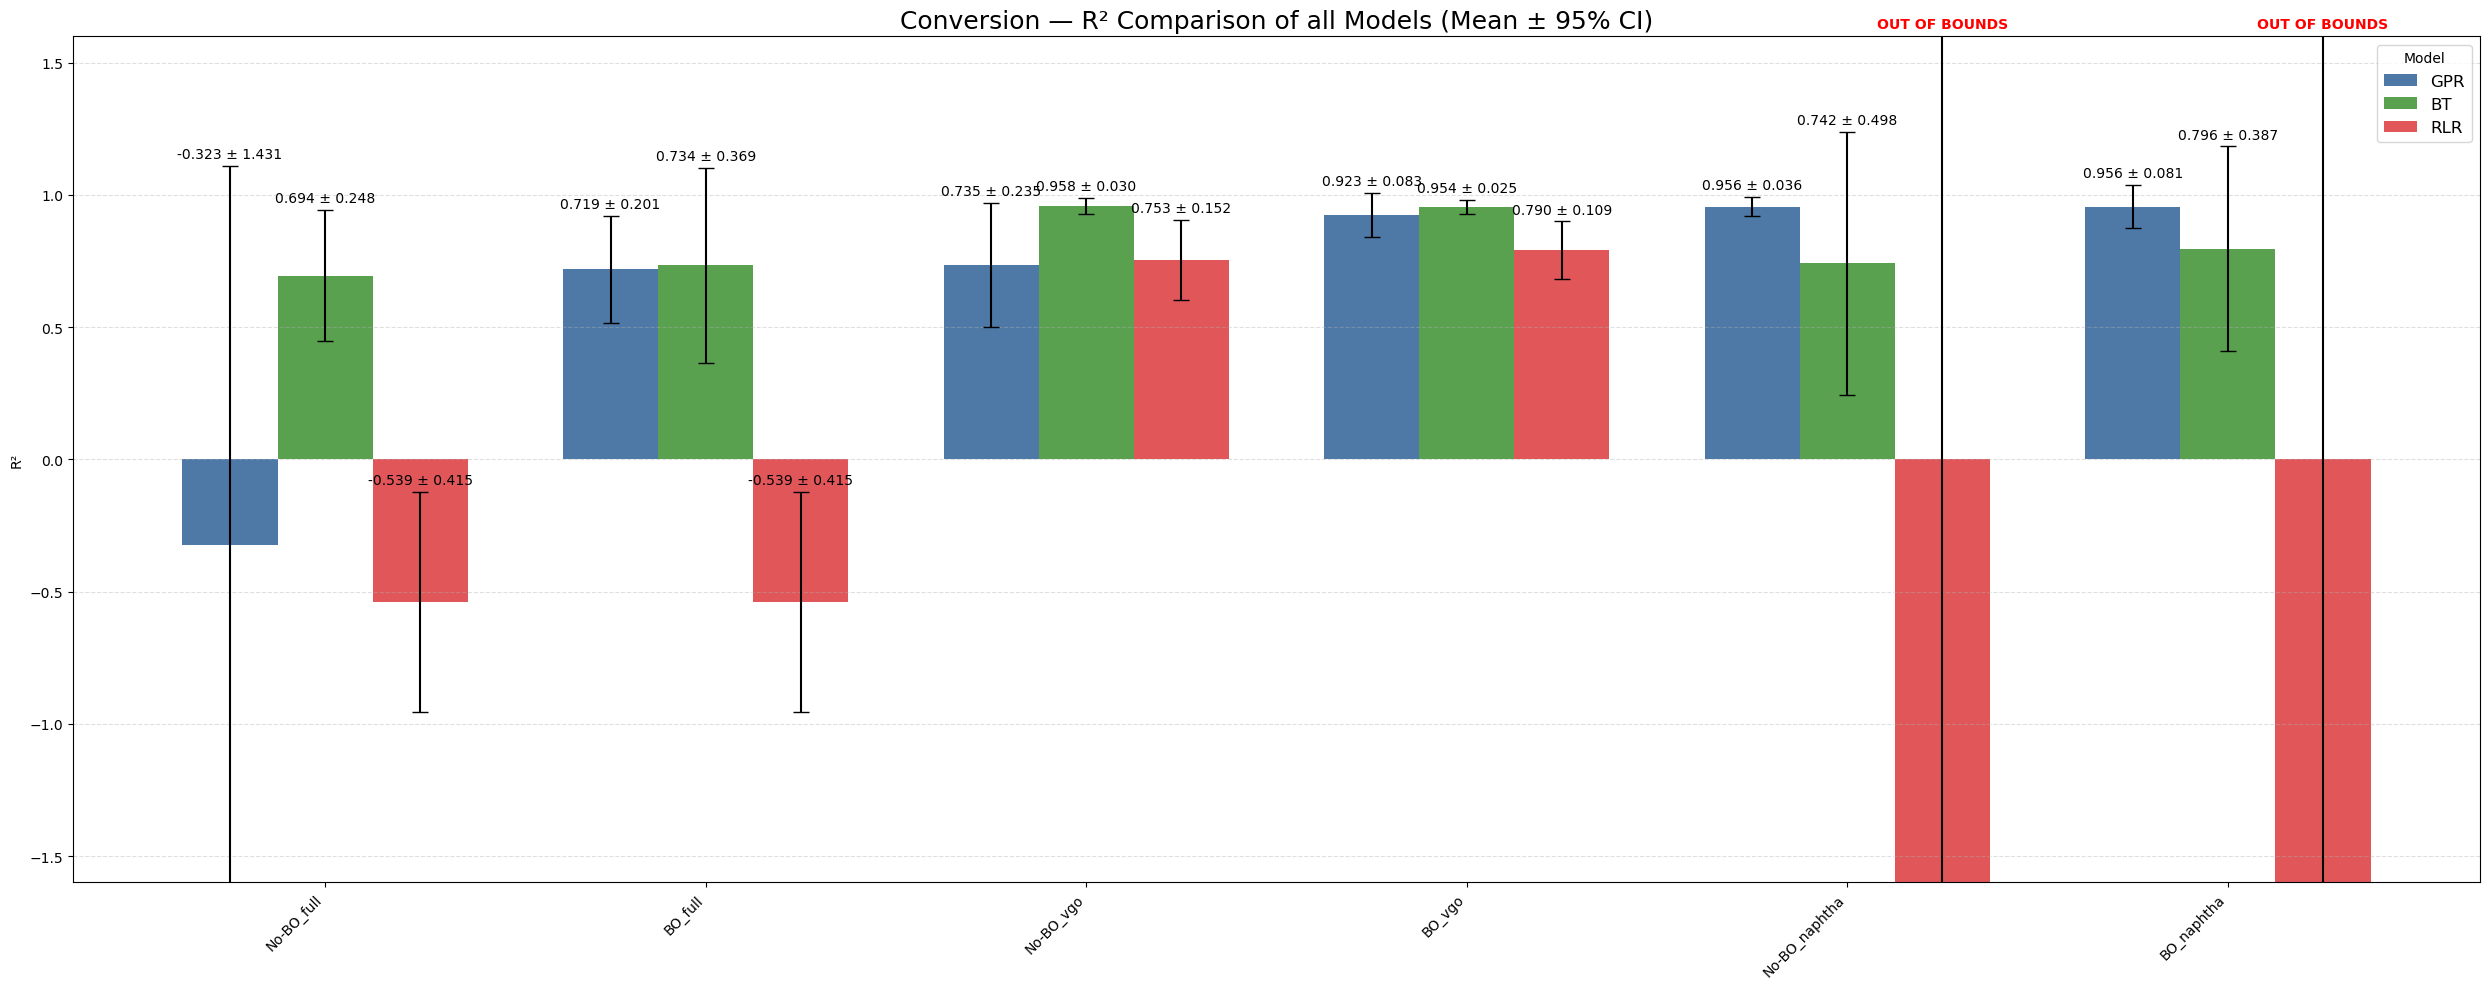

Saved figure as: R2_Model_Comparison_Conversion.png


In [8]:
# ============================================================================
# MULTI-MODEL R² COMPARISON BAR CHART — CONVERSION ONLY
# ============================================================================

metric = "R2"
target = "Conversion"
Z = 1.96  # 95% CI

# Filter only this target
df_conv = df[df["Target"] == target].copy()

conditions = [
    ("No-BO", "full"),
    ("BO", "full"),
    ("No-BO", "vgo"),
    ("BO", "vgo"),
    ("No-BO", "naphtha"),
    ("BO", "naphtha")
]

x_labels = [
    "No-BO_full",
    "BO_full",
    "No-BO_vgo",
    "BO_vgo",
    "No-BO_naphtha",
    "BO_naphtha"
]

model_colors = {
    "GPR": "#4E79A7",
    "BT":  "#59A14F",
    "RLR": "#E15759"
}

# Fix BO labels
df_conv["BO"] = df_conv["BO"].map({"Yes": "BO", "No": "No-BO"})

models = ["GPR", "BT", "RLR"]
models = [m for m in models if m in df_conv["Model"].unique()]

plt.figure(figsize=(25, 10))
plt.title("Conversion — R² Comparison of all Models (Mean ± 95% CI)", fontsize=18)

x = np.arange(len(x_labels))
bar_width = 0.25

for i, model in enumerate(models):
    means = []
    cis = []
    sub = df_conv[df_conv["Model"] == model]
    
    for bo, ds in conditions:
        vals = sub[(sub["BO"] == bo) & (sub["dataset"] == ds)][metric].values
        vals = vals[~np.isnan(vals)]
        
        if len(vals) == 0:
            means.append(np.nan)
            cis.append(0)
            continue
        
        mean = np.mean(vals)
        std = np.std(vals, ddof=1)
        n = len(vals)
        ci = Z * std / np.sqrt(n)
        
        means.append(mean)
        cis.append(ci)
    
    positions = x + (i - len(models)/2) * bar_width + bar_width/2
    
    bars = plt.bar(
        positions, means, yerr=cis, capsize=6, width=bar_width,
        label=model, color=model_colors[model]
    )
    
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        ci = cis[idx]
        xpos = bar.get_x() + bar.get_width()/2
        
        if np.isnan(height):
            plt.text(xpos, 0, "No data", ha="center", fontsize=10)
            continue
        
        if height < -1.6 or height > 1.6:
            plt.text(xpos, 1.62, "OUT OF BOUNDS", 
                     ha="center", va="bottom", color="red", fontsize=10, fontweight="bold")
        else:
            plt.text(xpos, height + ci + 0.03, f"{height:.3f} ± {ci:.3f}", 
                     ha='center', fontsize=10)

plt.xticks(x, x_labels, rotation=45, ha="right")
plt.ylabel("R²")
plt.ylim(-1.6, 1.6)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Model", fontsize=12)
plt.tight_layout()

save_path = "R2_Model_Comparison_Conversion.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure as: {save_path}")

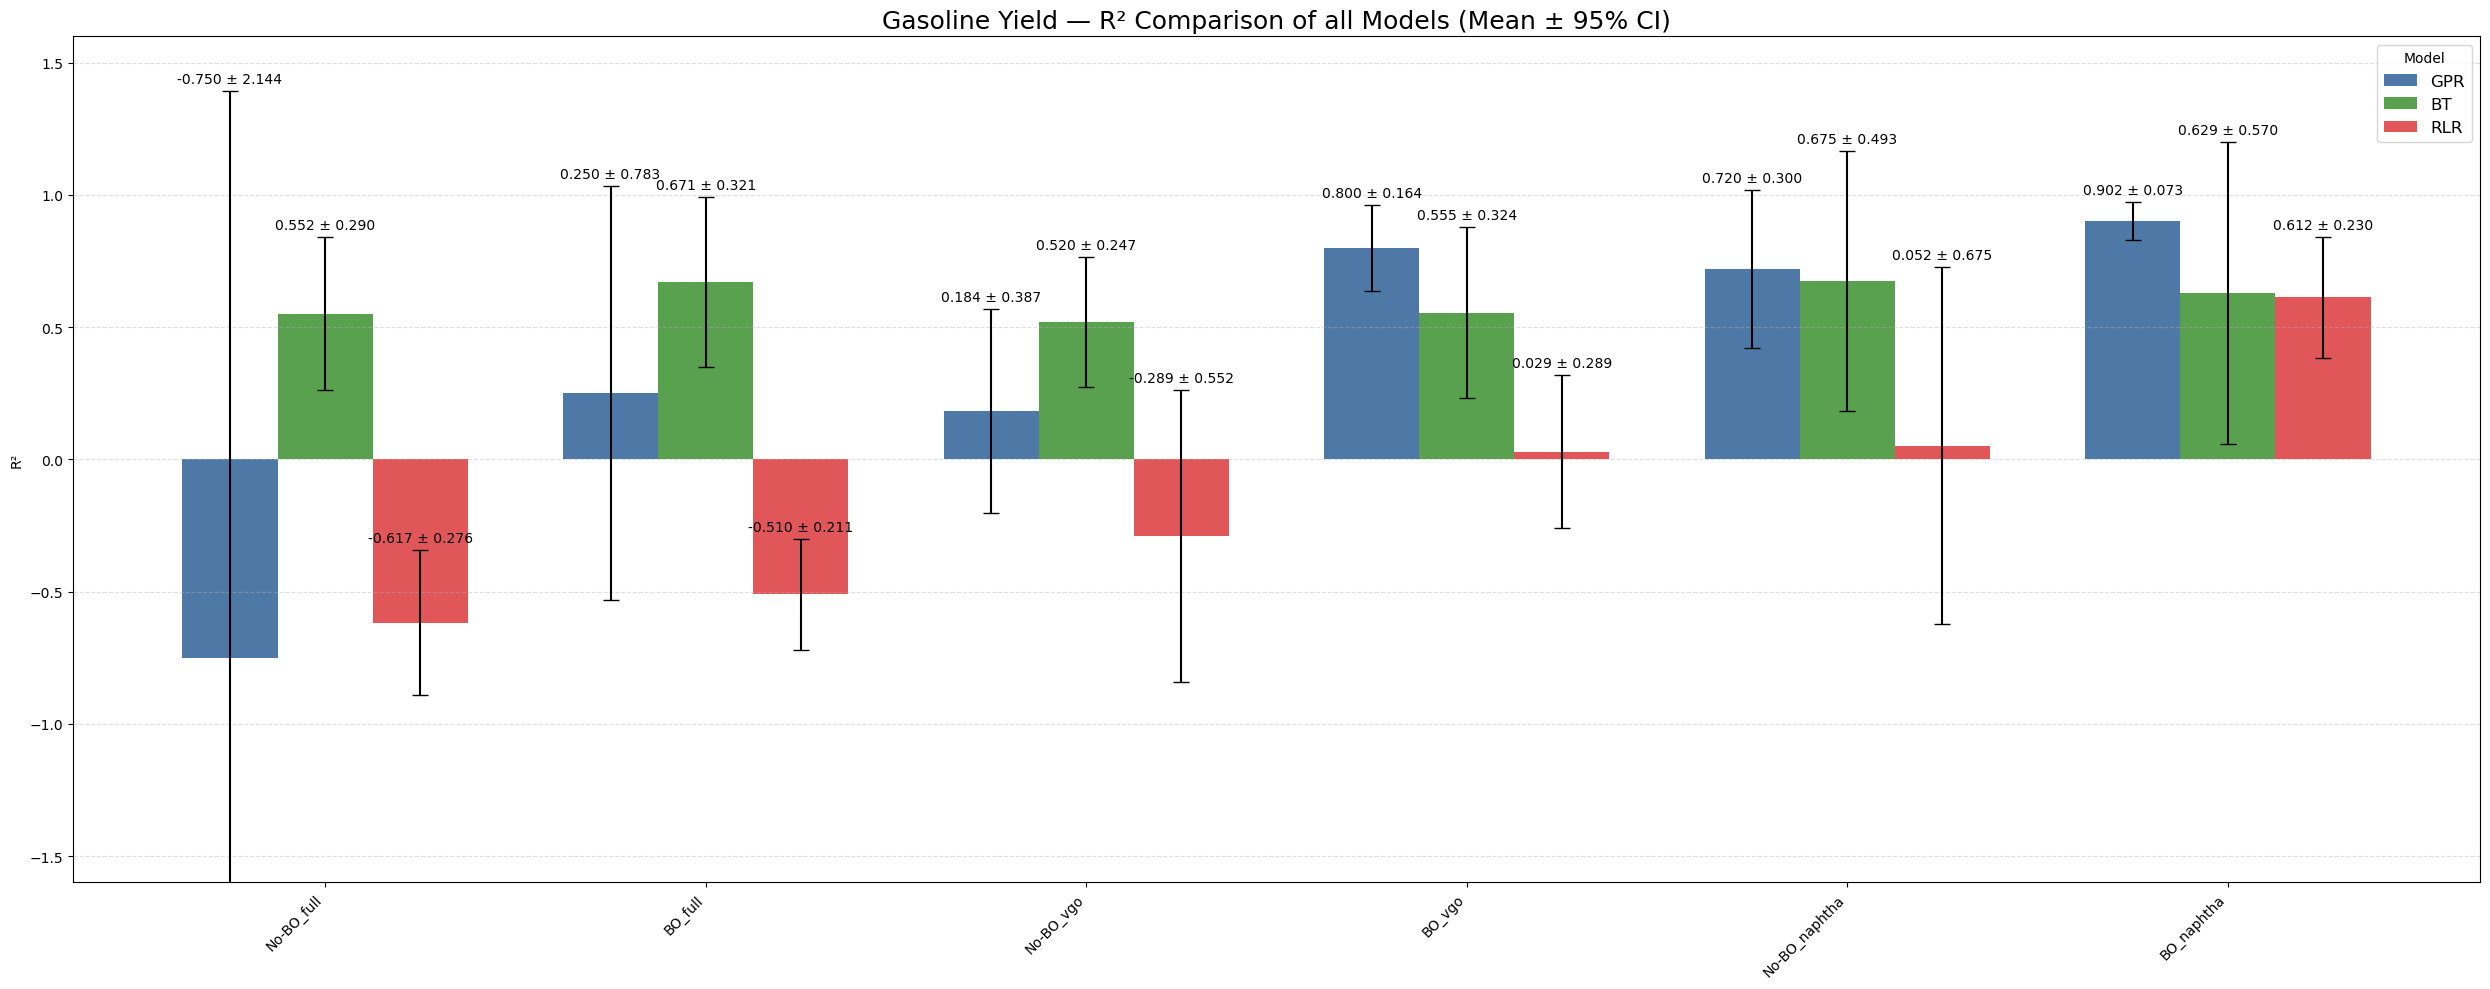

Saved figure as: R2_Model_Comparison_Yield.png


In [9]:
# ============================================================================
# MULTI-MODEL R² COMPARISON BAR CHART — GASOLINE YIELD ONLY
# ============================================================================

metric = "R2"
target = "Gasoline Yield"
Z = 1.96

df_yield = df[df["Target"] == target].copy()

conditions = [
    ("No-BO", "full"),
    ("BO", "full"),
    ("No-BO", "vgo"),
    ("BO", "vgo"),
    ("No-BO", "naphtha"),
    ("BO", "naphtha")
]

x_labels = [
    "No-BO_full",
    "BO_full",
    "No-BO_vgo",
    "BO_vgo",
    "No-BO_naphtha",
    "BO_naphtha"
]

model_colors = {
    "GPR": "#4E79A7",
    "BT":  "#59A14F",
    "RLR": "#E15759"
}

df_yield["BO"] = df_yield["BO"].map({"Yes": "BO", "No": "No-BO"})

models = ["GPR", "BT", "RLR"]
models = [m for m in models if m in df_yield["Model"].unique()]

plt.figure(figsize=(25, 10))
plt.title("Gasoline Yield — R² Comparison of all Models (Mean ± 95% CI)", fontsize=18)

x = np.arange(len(x_labels))
bar_width = 0.25

for i, model in enumerate(models):
    means = []
    cis = []
    sub = df_yield[df_yield["Model"] == model]
    
    for bo, ds in conditions:
        vals = sub[(sub["BO"] == bo) & (sub["dataset"] == ds)][metric].values
        vals = vals[~np.isnan(vals)]
        
        if len(vals) == 0:
            means.append(np.nan)
            cis.append(0)
            continue
        
        mean = np.mean(vals)
        std = np.std(vals, ddof=1)
        n = len(vals)
        ci = Z * std / np.sqrt(n)
        
        means.append(mean)
        cis.append(ci)
    
    positions = x + (i - len(models)/2) * bar_width + bar_width/2
    
    bars = plt.bar(
        positions, means, yerr=cis, capsize=6, width=bar_width,
        label=model, color=model_colors[model]
    )
    
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        ci = cis[idx]
        xpos = bar.get_x() + bar.get_width()/2
        
        if np.isnan(height):
            plt.text(xpos, 0, "No data", ha="center", fontsize=10)
            continue
        
        if height < -1.6 or height > 1.6:
            plt.text(xpos, 1.62, "OUT OF BOUNDS", 
                     ha="center", va="bottom", color="red", fontsize=10, fontweight="bold")
        else:
            plt.text(xpos, height + ci + 0.03, f"{height:.3f} ± {ci:.3f}", 
                     ha='center', fontsize=10)

plt.xticks(x, x_labels, rotation=45, ha="right")
plt.ylabel("R²")
plt.ylim(-1.6, 1.6)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Model", fontsize=12)
plt.tight_layout()

save_path = "R2_Model_Comparison_Yield.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure as: {save_path}")